In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
    
    

In [2]:
import sys
import math
import random
from numba import jit
from skimage.feature import peak_local_max
import itertools

import scipy.spatial

# 1 Gaussian and Laplacian Pyramids

In [3]:
def reduce(g_1,k):
    h,w = g_1.shape
    new_h=int(h/2.)
    new_w=int(w/2.)
    g= np.zeros(shape=(new_h,new_w))
    for i in range(0,new_h):
        for j in range(0,new_w):
            for m in range(-2,2):
                for n in range(-2,2):
                    g[i,j]+=k[m,n]*g_1[2*i+m,2*j+n]
    return g

In [4]:
def pyramidG(orig,kernel,size):
    pyr=[]
    prev=orig
    for i in range(0,size):
        pyr.append(prev)
        prev=reduce(prev,kernel)
    return pyr

In [5]:
kernel=cv2.getGaussianKernel(5, 1.4) 
kernel=kernel.dot(kernel.T)

In [6]:
yos0 = cv2.imread('./images/DataSeq1/yos_img_01.jpg',0) 



In [7]:
pg=pyramidG(yos0,kernel,4)

## 1-1

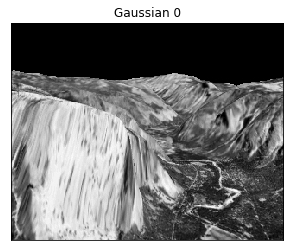

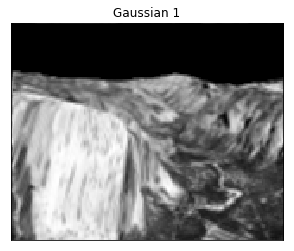

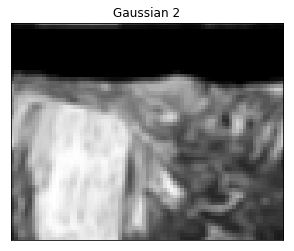

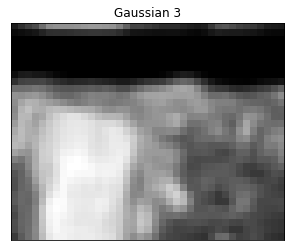

In [8]:
for i,img in enumerate(pg):
    h,w = img.shape
    plt.imshow(img,cmap='gray')
    plt.title('Gaussian '+str(i)), plt.xticks([]), plt.yticks([])
    plt.show()

In [9]:
def expand(g,k,prev_odd_w,prev_odd_h):
    h,w = g.shape
    new_h= (h)*2 
    new_h_resized=new_h
    if(prev_odd_h):
        new_h_resized+=1
    new_w= (w)*2
    
    new_w_resized=new_w
 
    if(prev_odd_w):
        new_w_resized+=1
    g_n= np.zeros(shape=(new_h_resized,new_w_resized))
    
    for i in range(2,new_h-2):
        for j in range(2,new_w-2):
            for m in range(-2,2):
                for n in range(-2,2):
                    new_i=(i-m)/2
                    new_j=(j-n)/2
                    if(new_i.is_integer() and new_j.is_integer()):
                        g_n[i,j]+=k[m,n]*g[int(new_i),int(new_j)]
    return 4*g_n

In [10]:
def pyramidL(orig,kernel,n):
    pg=pyramidG(yos0,kernel,n)
    pyr=[]
    prev=orig
    for j in range(0,n-1):
            prev_odd_h=False
            prev_odd_w=False
            gauss=pg[j]
            h,w = gauss.shape
            if(h%2 ==1):
                prev_odd_h=True
            if(w%2 ==1):
                prev_odd_w=True
            
            gauss1=pg[j+1]
            exp=expand(gauss1,kernel, prev_odd_w, prev_odd_h)
            h,w = exp.shape
            
            gaussN=cv2.normalize(gauss,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
            expN=cv2.normalize(exp,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            
         
            
            prev_lap= gaussN-expN            
            pyr.append(prev_lap)
    pyr.append(pg[n-1])    
    return pyr

In [11]:
p=pyramidL(yos0,kernel,4)

## 1-2

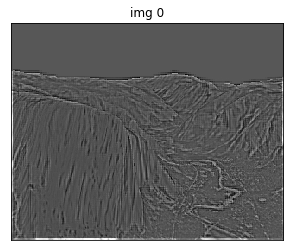

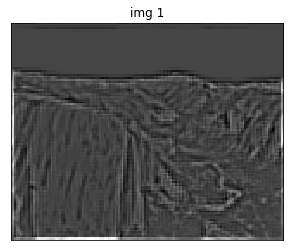

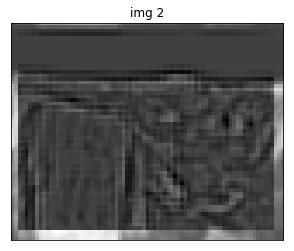

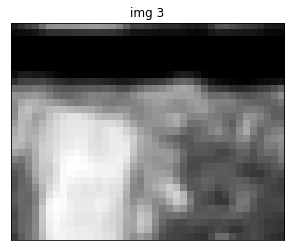

In [12]:
for i,img in enumerate(p):
        h,w = img.shape
        plt.imshow(img,cmap='gray')
        plt.title('img '+str(i)), plt.xticks([]), plt.yticks([])
        plt.show()

# 2 -  Lucas Kanade optic flow

In [13]:
def solveLK(M,b,e=1e-8):
    UV=np.zeros((2,1))
    if (np.linalg.det(M)>e):
        UV=np.linalg.inv(M).dot(b)
    return UV

In [14]:
def LK(ImgA,ImgB,win):
    gxx,gyy=np.gradient(ImgA)
    
    
        
    gxx2=gxx*gxx
    gyy2=gyy*gyy
    gxxyy=gxx*gyy
    
    Ixx=cv2.boxFilter(gxx2,-1,(win,win))       
    
    Iyy=cv2.boxFilter(gyy2,-1,(win,win))
    
    Ixy=cv2.boxFilter(gxxyy,-1,(win,win))
    
    It=cv2.subtract(ImgB,ImgA)
    

    Itx=-cv2.boxFilter(It*gxx,-1,(win,win))
    Ity=-cv2.boxFilter(It*gyy,-1,(win,win))
    
    
    
    h,w=ImgA.shape
    R= np.zeros(shape=(h,w))
    
    halfWin=win//2
    UV= []
    UV.append(np.zeros(shape=(h,w)))
    UV.append(np.zeros(shape=(h,w)))
  
            
    for i in range(halfWin,h-halfWin):
        for j in range(halfWin,w-halfWin):
            M=np.array([[Ixx[i, j],Ixy[i,j]] , [Ixy[i, j],Iyy[i,j]]], np.float32)
            b=[Itx[i,j],Ity[i,j]]
            uv=solveLK(M,b)
            #print(uv)
            UV[0][i,j]=uv[0]
            UV[1][i,j]=uv[1]
    return UV

In [15]:
def printLK(img, UV, title="Title",step = 50):
    u=UV[0]
    v=UV[1]
    
    x = np.arange(0, img.shape[1], 1)
    y = np.arange(0, img.shape[0], 1)
    x, y = np.meshgrid(x, y)
    plt.figure(figsize=(10,5))
    fig = plt.imshow(img, cmap = 'gray')
    # step to be display
    step = int(img.shape[0] / step)
    
    plt.quiver(x[::step], y[::step],
               u[::step], v[::step], color = 'blue',
               pivot = 'middle', headwidth=1, headlength =1)
    plt.imshow(img,cmap='gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()


In [16]:
def quiver(img, u,v, step = 50):

    
    x = np.arange(0, img.shape[1], 1)
    y = np.arange(0, img.shape[0], 1)
    x, y = np.meshgrid(x, y)
    plt.figure(figsize=(10,5))
    fig = plt.imshow(img, cmap = 'gray')
    # step to be display
    step = int(img.shape[0] / step)
    
    plt.quiver(x[::step], y[::step],
               u[::step], v[::step], color = 'blue',
               pivot = 'middle', headwidth=1, headlength =1)
    plt.imshow(img,cmap='gray')
    plt.title('Quiver picture '), plt.xticks([]), plt.yticks([])
    plt.show()


In [17]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s2 = cv2.imread('./images/TestSeq/ShiftR2.png',0) 

## 2-1

In [18]:
s2UV=LK(s0,s2,10)


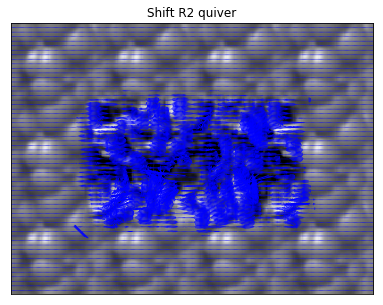

In [19]:
printLK(s0,s2UV,"Shift R2 quiver")

In [20]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s5 = cv2.imread('./images/TestSeq/ShiftR5U5.png',0) 
UV=LK(s0,s5,10)


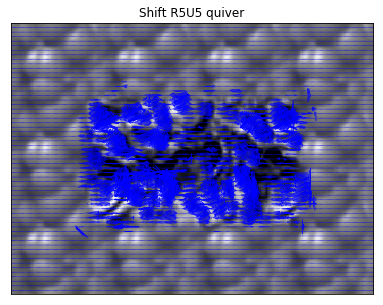

In [21]:
printLK(s0,UV,"Shift R5U5 quiver")

## 2-2

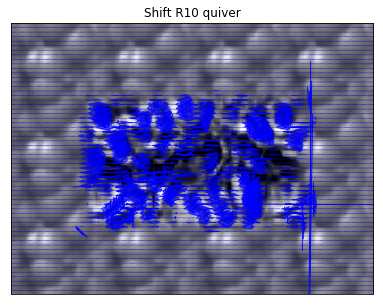

In [22]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s10 = cv2.imread('./images/TestSeq/ShiftR10.png',0) 
UV=LK(s0,s10,10)
printLK(s0,UV,"Shift R10 quiver")

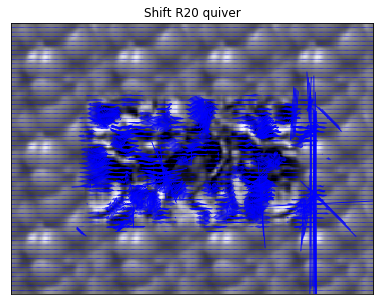

In [23]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s20 = cv2.imread('./images/TestSeq/ShiftR20.png',0) 
UV=LK(s0,s20,10)
printLK(s0,UV,"Shift R20 quiver")

#### We can see that the blurring is not good enough, let's try more bluring

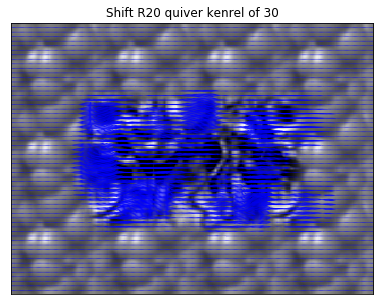

In [24]:
UV=LK(s0,s20,30)
printLK(s0,UV,"Shift R20 quiver kenrel of 30")

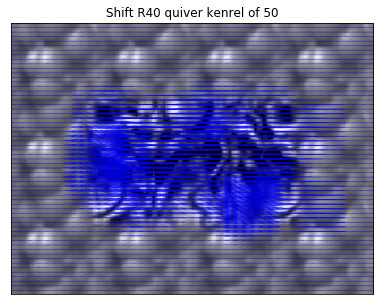

In [25]:
s0 = cv2.imread('./images/TestSeq/Shift0.png',0) 
s40 = cv2.imread('./images/TestSeq/ShiftR40.png',0) 
UV=LK(s0,s40,50)
printLK(s0,UV,"Shift R40 quiver kenrel of 50")

## 2-3

In [26]:
def wrap(imgB,u,v):

    h,w=imgB.shape
    x = np.arange(0, w, 1)
    y = np.arange(0, h, 1)
    x, y = np.meshgrid(x, y)
    
    mU = np.array(x + u, dtype=np.float32)
    mV = np.array(y + v, dtype=np.float32)
    
    wrap3=cv2.remap(imgB,mU,mV, interpolation=cv2.INTER_NEAREST)
    wrap2=cv2.remap(imgB,mU,mV, interpolation=cv2.INTER_LINEAR)
    Nans=np.isnan(wrap2)
    wrap2[Nans]=wrap3[Nans]
    return wrap2

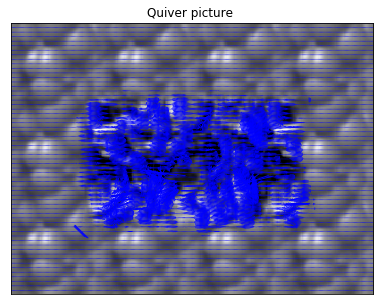

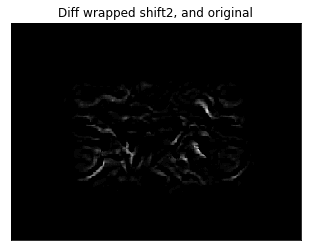

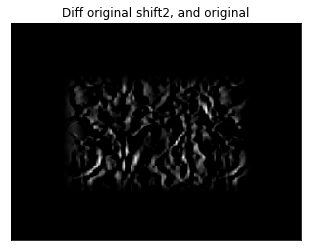

In [27]:
u=s2UV[0]
v=s2UV[1]
ws2 = wrap(s2, u,v)

quiver(s0,u,v)


diff = cv2.subtract(s2, ws2)
plt.imshow(diff, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Diff wrapped shift2, and original')
plt.show()


diff = cv2.subtract(s2, s0)
plt.imshow(diff, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Diff original shift2, and original')
plt.show()

## 3  Hierarchical LK optic flow

In [28]:
def pyrLK(imgA,imgB,n=5,wSize=5,verbose=False):

    
    for k in range(n,0,-1):
        redA=imgA
        redB=imgB
        for i in range(1,k):
            redA=reduce(redA,kernel)
            redB=reduce(redB,kernel)


        h,w=redA.shape#3

        if(h%2==0):
            prev_odd_h=False
        else:
            prev_odd_h=True


        if(w%2==0):
            prev_odd_w=False
        else:
            prev_odd_w=True

        if(n==k):
            U=np.zeros(shape=(h,w))
            V=np.zeros(shape=(h,w))
        else:
            U=2*expand(U,kernel,prev_odd_w,prev_odd_h)
            V=2*expand(V,kernel,prev_odd_w,prev_odd_h)

        #4 Warp Lk using U and V to form Wk.
        Wk = wrap(redA, U, V)
        
        if(verbose):
            plt.imshow(Wk, cmap = 'gray')
            plt.xticks([]), plt.yticks([])
            plt.show()

            plt.imshow(redB, cmap = 'gray')
            plt.xticks([]), plt.yticks([])
            plt.show()
        
        #5 Perform LK on Wk and Rk to yield two incremental flow fields Dx and Dy.
        UV = LK(Wk, redB, wSize)
        U=U+UV[0]
        V=V+UV[1]
        #6 v
        
    return U,V, Wk
    

In [29]:
shift0 = cv2.GaussianBlur(cv2.imread('./images/TestSeq/Shift0.png', 0), (3,3), 5)
shiftR2 = cv2.GaussianBlur(cv2.imread('./images/TestSeq/ShiftR2.png', 0), (3,3), 5)
shiftR5U5 = cv2.GaussianBlur(cv2.imread('./images/TestSeq/ShiftR5U5.png', 0), (3,3), 5)
shiftR10 = cv2.GaussianBlur(cv2.imread('./images/TestSeq/ShiftR10.png', 0), (3,3), 5)
shiftR20 = cv2.GaussianBlur(cv2.imread('./images/TestSeq/ShiftR20.png', 0), (3,3), 5)
shiftR40 = cv2.GaussianBlur(cv2.imread('./images/TestSeq/ShiftR40.png', 0), (3,3), 5)



## 3-1

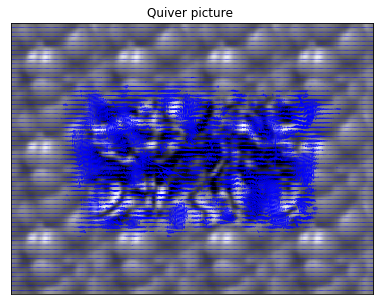

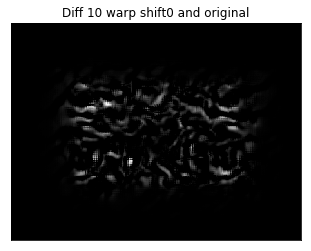

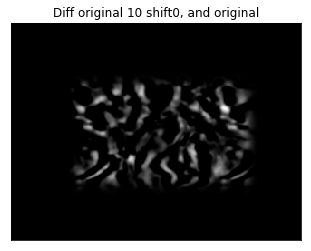

In [30]:
#δ pixels, you’ll need to set n to (at least) log2(δ) -> 4
flowU_R10, flowV_R10, warped_L_R10 = pyrLK(shift0, shiftR10, n = 4)
quiver(shift0, flowU_R10, flowV_R10)

diff = cv2.subtract(shift0, warped_L_R10)
plt.imshow(diff, cmap='gray')
plt.title('Diff 10 warp shift0 and original')
plt.xticks([]), plt.yticks([])
plt.show()

diff = cv2.subtract(shift0, shiftR10)
plt.imshow(diff, cmap='gray')
plt.title('Diff original 10 shift0, and original')
plt.xticks([]), plt.yticks([])
plt.show()

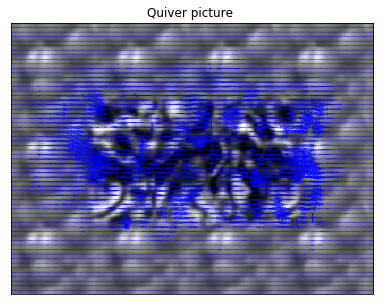

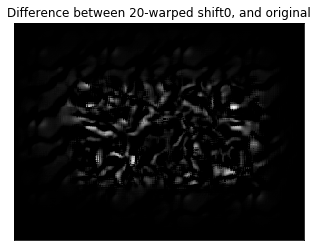

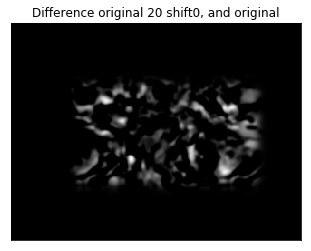

In [31]:
#δ pixels, you’ll need to set n to (at least) log2(δ).
flowU_R20, flowV_R20, warped_L_R20 = pyrLK(shift0, shiftR20, n = 5)
quiver(shift0, flowU_R20, flowV_R20)

diff = cv2.subtract(shift0, warped_L_R20)
plt.imshow(diff, cmap='gray')
plt.title('Difference between 20-warped shift0, and original')
plt.xticks([]), plt.yticks([])
plt.show()

diff = cv2.subtract(shift0, shiftR20)
plt.imshow(diff, cmap='gray')
plt.title('Difference original 20 shift0, and original')
plt.xticks([]), plt.yticks([])
plt.show()

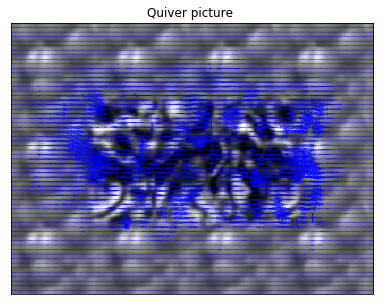

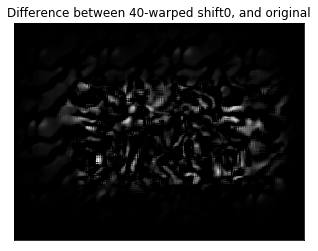

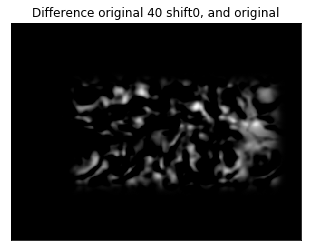

In [32]:
#δ pixels, you’ll need to set n to (at least) log2(δ).
flowU_R40, flowV_R40, warped_L_R40 = pyrLK(shift0, shiftR40, n = 5)
quiver(shift0, flowU_R20, flowV_R20)

diff = cv2.subtract(shift0, warped_L_R40)
plt.imshow(diff, cmap='gray')
plt.title('Difference between 40-warped shift0, and original')
plt.xticks([]), plt.yticks([])
plt.show()

diff = cv2.subtract(shift0, shiftR40)
plt.imshow(diff, cmap='gray')
plt.title('Difference original 40 shift0, and original')
plt.xticks([]), plt.yticks([])
plt.show()

In [33]:
juggle0 = cv2.GaussianBlur(cv2.imread('./images/Juggle/0.png', 0), (5,5), sigmaX = 5, sigmaY =5)
juggle1 = cv2.GaussianBlur(cv2.imread('./images/Juggle/1.png', 0), (5,5), sigmaX = 5, sigmaY =5)
juggle2 = cv2.GaussianBlur(cv2.imread('./images/Juggle/2.png', 0), (5,5), sigmaX = 5, sigmaY =5)


# 4 The Juggle Sequence

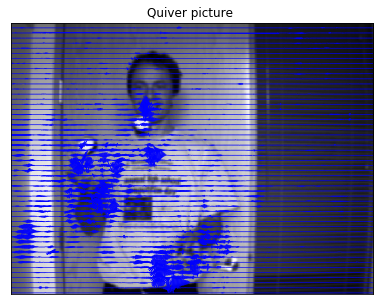

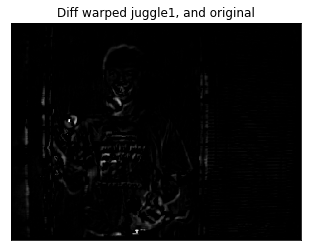

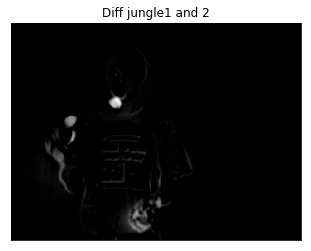

In [34]:
u, v, warped_juggle = pyrLK(juggle1, juggle2, n =5)
quiver(juggle1, u,v)

diff = cv2.subtract(juggle1, warped_juggle)
plt.imshow(diff, cmap='gray')
plt.title('Diff warped juggle1, and original')
plt.xticks([]), plt.yticks([])
plt.show()


diff = cv2.subtract(juggle1, juggle2)
plt.imshow(diff, cmap='gray')
plt.title('Diff jungle1 and 2')
plt.xticks([]), plt.yticks([])
plt.show()

# 5 The Taxi Sequence

In [35]:
taxi0 = cv2.imread('./images/Taxis/taxi-00.jpg', 0)
h,w = taxi0.shape

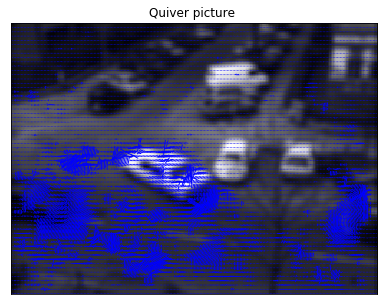

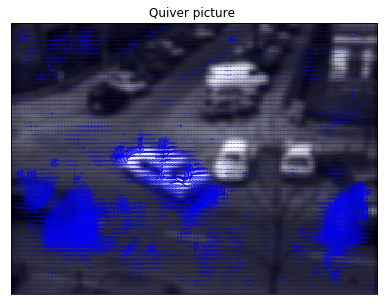

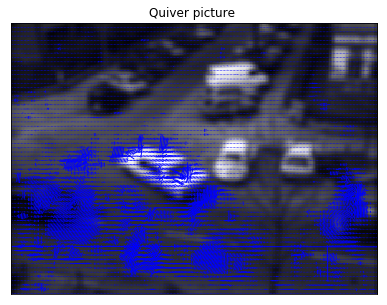

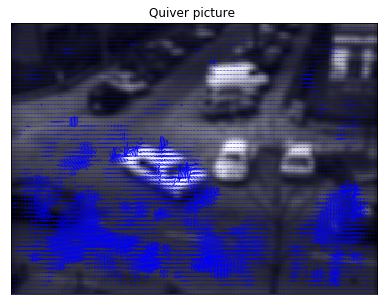

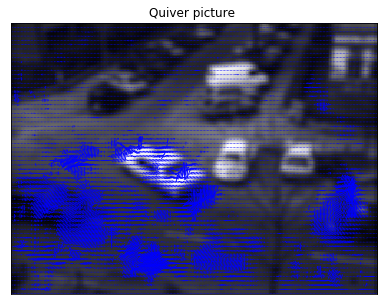

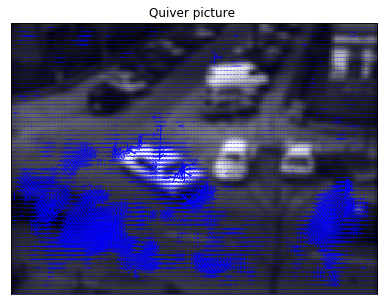

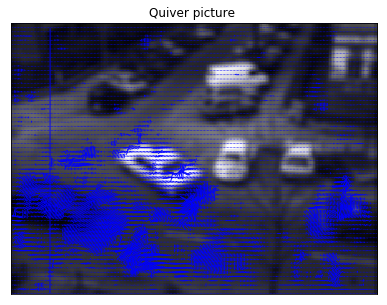

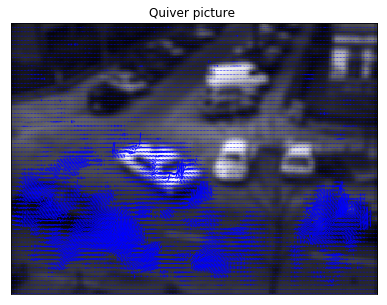

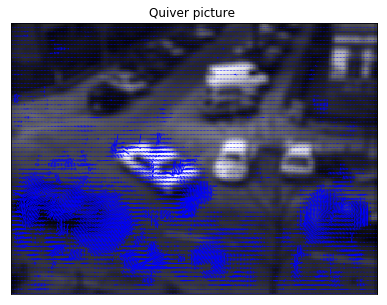

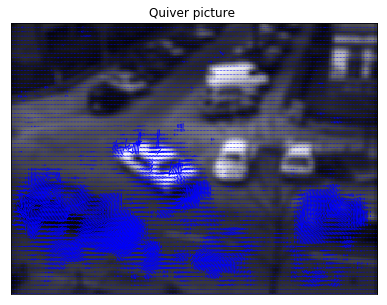

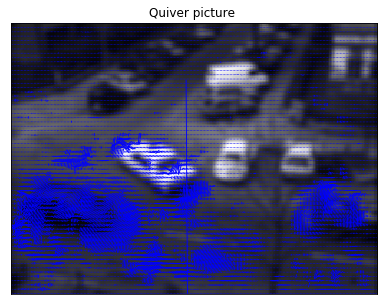

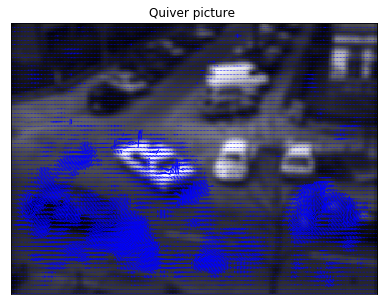

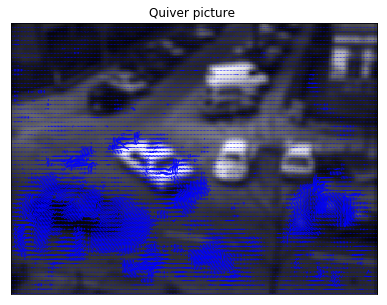

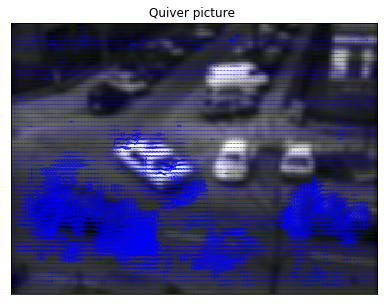

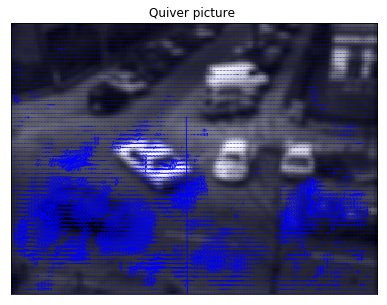

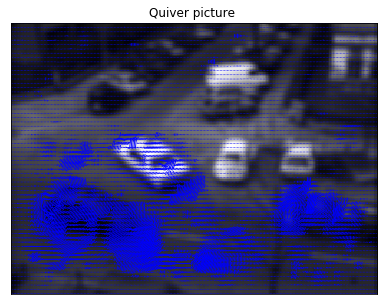

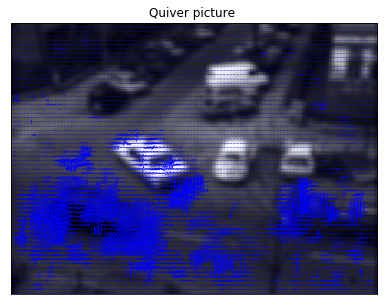

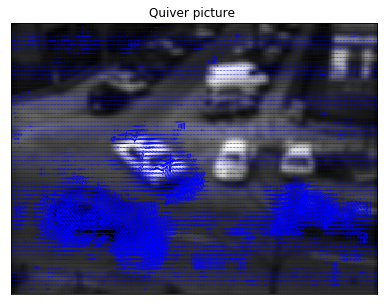

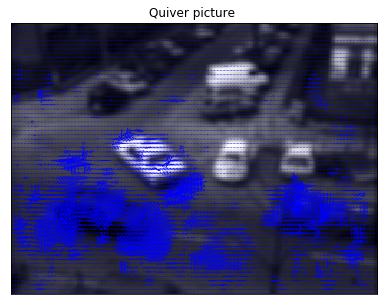

In [36]:

for i in range(0, 19):
    str_i1 = ('0'+str(i))[-2:];
    str_i2 = ('0'+str(i+1))[-2:];
    taxi1 =  cv2.GaussianBlur(cv2.imread('./images/Taxis/taxi-'+str_i1+'.jpg', 0), (5,5), sigmaX = 5, sigmaY =5)
    taxi2 =  cv2.GaussianBlur(cv2.imread('./images/Taxis/taxi-'+str_i2+'.jpg', 0), (5,5), sigmaX = 5, sigmaY =5)
    # need smoothing ?
    u,v, warp = pyrLK(taxi1, taxi2, n = 3)
    quiver(taxi1, u,v)
    